# Categorização de produtos usando Doc2Vec
## classificador: LightGBM

Bibliotecas e Configurações

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 
import boto3
import gensim
import lightgbm as lgb
from typing import List

from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.utils import simple_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import classification_report


Importando o Dataset

In [2]:
path = 's3://data/'
file_train = 'sample_products.csv'
file_test =  'test_products.csv'
endpoint_url='http://minio:9000'
AWS_ACCESS_KEY_ID = 'minio'
AWS_SECRET_ACCESS_KEY = 'minio123'
storage_options={
        "key": AWS_ACCESS_KEY_ID,
        "secret": AWS_SECRET_ACCESS_KEY,
        "client_kwargs": {"endpoint_url": endpoint_url}
    }

df_train = pd.read_csv(path+file_train,storage_options=storage_options)
df_test = pd.read_csv(path+file_test,storage_options=storage_options)

Verificando colunas dos Datasets

In [3]:
print(df_train.columns)
print(df_test.columns)

Index(['product_id', 'seller_id', 'query', 'search_page', 'position', 'title',
       'concatenated_tags', 'creation_date', 'price', 'weight',
       'express_delivery', 'minimum_quantity', 'view_counts', 'order_counts',
       'category'],
      dtype='object')
Index(['product_id', 'seller_id', 'query', 'search_page', 'position', 'title',
       'concatenated_tags', 'creation_date', 'price', 'weight',
       'express_delivery', 'minimum_quantity', 'view_counts', 'order_counts',
       'category'],
      dtype='object')


Analisando os dados

In [4]:
print("Número de Linhas por categoria:")
print(df_train['category'].value_counts())
print(df_test['category'].value_counts())

Número de Linhas por categoria:
Lembrancinhas         17524
Decoração              8723
Bebê                   6930
Papel e Cia            2750
Outros                 1133
Bijuterias e Jóias      940
Name: category, dtype: int64
Lembrancinhas         230
Decoração             122
Bebê                   95
Papel e Cia            27
Outros                 15
Bijuterias e Jóias     11
Name: category, dtype: int64


Plotando o número de produtos por categoria

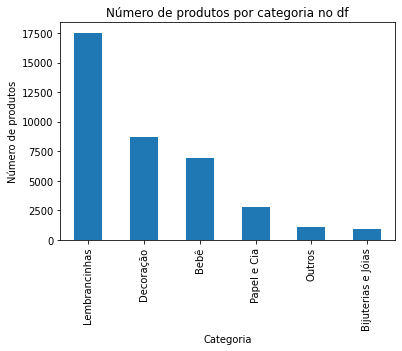

In [5]:
plt.figure()
pd.value_counts(df_train['category']).plot.bar(title="Número de produtos por categoria no df")
plt.xlabel("Categoria")
plt.ylabel("Número de produtos")
plt.show()

Podemos perceber que o número de produtos por categoria não é similar.

Uma possivel abordagem é o uso de algoritmos baseados em árvore de dedicão, onde  mesmo com o desbalanceamento de classe a árvore de decisão consegue crescer para as categorias com mais dados, sem impactar a performance de categorias com menos dados de treinamento.

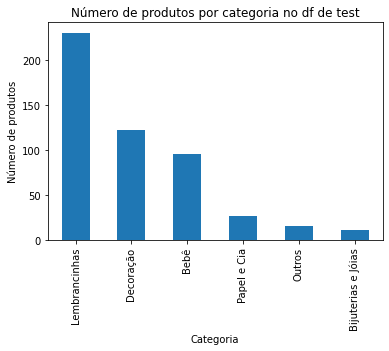

In [6]:
plt.figure()
pd.value_counts(df_test['category']).plot.bar(title="Número de produtos por categoria no df de test")
plt.xlabel("Categoria")
plt.ylabel("Número de produtos")
plt.show()

### Pré-processamento

Deduplicar produtos no df

In [7]:
(df_test
.loc[lambda f : f['product_id'].isin(set(df_train.product_id.to_list()))])

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
4,5190417,2497208,vaso de barro atacado,1,23,30 Mini Vaso 6cm Cerâmica Lembrancinha casamen...,cha bebe lhama mini vasos c adesivos,2018-10-19 00:22:33,11.47,2009.0,1,39,741,NaN,Lembrancinhas
5,10824861,7704056,painel macrame,1,19,Painel Macramê Boho Aiyra,tecer macrame,2018-06-02 15:50:11,269.75,9.0,1,1,584,20.0,Decoração
23,14174092,9631672,lembrancas para formatura de direito,1,8,Copo Personalizado Formatura Direito,formatura,2018-04-26 21:51:25,11.14,0.0,1,103,398,NaN,Lembrancinhas
24,1986516,8225602,pulseira para madrinha de casamento,1,36,Kit 12 Pulseiras Madrinhas Folheada Ouro Casam...,madrinhas noivas noivas pulseira ouro,2017-10-09 10:52:20,130.70,12.0,1,1,221,9.0,Bijuterias e Jóias
27,3926411,6406087,15 anos,3,26,COPO 15 ANOS PERSONALIZADO,aniversario 15 anos lembrancinha 15 anos camilly,2018-05-24 13:17:01,1.89,7.0,1,110,870,NaN,Lembrancinhas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,1641768,7565210,lembrancinha patrulha canina,5,18,50 Apliques Patrulha Canina,patrulha canina papelaria festa 4o aniversario...,2016-11-25 23:33:52,26.26,13.0,1,4,625,61.0,Papel e Cia
486,4374398,7223369,necessaire personalizada,5,23,Lembrança - necessaire personalizada P,lembranca casamento necessaire clinica,2017-07-11 08:38:56,20.66,5.0,1,10,260,8.0,Lembrancinhas
487,10262909,2597184,kit fraldas de boca,1,4,Kit Fraldas de Boca Nuvem,fralda boca anuncio gravidez kit fraldas,2017-07-25 11:37:19,67.41,235.0,1,6,1026,22.0,Bebê
489,9488501,1433098,lembrancinha dia dos pais,5,19,Caneca Personalizada Dia dos pais -Lembrancinh...,caneca personalizada dia pais lembrancinha dia...,2017-06-25 20:55:46,23.23,606.0,1,1,184,21.0,Lembrancinhas


Retirando produtos duplicados do conjunto de treinamento

In [8]:
df_train = (df_train.loc[lambda f : ~f['product_id'].isin(set(df_test.product_id.to_list()))])

In [9]:
df_copy = df_train.copy()
df_copy_test = df_test.copy()
df_copy = df_copy.drop_duplicates('product_id')
df_copy_test = df_copy_test.drop_duplicates('product_id')

Concatenando título, query e tags

In [10]:

df_copy["text"] = df_copy["concatenated_tags"] + " " + df_copy["title"]
df_copy = df_copy[df_copy["text"].notnull()]

df_copy_test["text"] = df_copy_test["concatenated_tags"] + " " + df_copy_test["title"]
df_copy_test = df_copy_test[df_copy_test["text"].notnull()]

Criar uma coluna para cada categoria, para realizar o one-hot-encoding

In [11]:
df_copy = df_copy.fillna(0)
df_one = pd.get_dummies(df_copy.category)
print(df_one.head())
df_copy = pd.concat([df_copy, df_one], axis=1)

df_copy_test = df_copy_test.fillna(0)
df_one_test = pd.get_dummies(df_copy_test.category)
print(df_one_test.head())
df_copy_test = pd.concat([df_copy_test, df_one_test], axis=1)

   Bebê  Bijuterias e Jóias  Decoração  Lembrancinhas  Outros  Papel e Cia
0     0                   0          1              0       0            0
1     0                   0          0              0       0            1
2     0                   0          0              0       1            0
3     1                   0          0              0       0            0
4     0                   0          1              0       0            0
   Bebê  Bijuterias e Jóias  Decoração  Lembrancinhas  Outros  Papel e Cia
0     0                   0          0              1       0            0
1     0                   0          1              0       0            0
2     0                   0          0              1       0            0
3     0                   0          0              1       0            0
4     0                   0          0              1       0            0


### Extração das Features e Construção do Dicionário

Tokeniza as celulas

In [12]:
df_copy['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in df_copy['concatenated_tags']]
df_copy_test['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in df_copy_test['concatenated_tags']] 
print(df_copy['tokenized_text'].head(10))

0                                       [mandala, mdf]
1    [cartao, visita, panfletos, tag, adesivos, cop...
2                                          [expositor]
3                [jogo, lencol, menino, lencol, berco]
4                             [adesivo, box, banheiro]
5       [albuns, figurinhas, pai, lucas, album, fotos]
6                                     [mini, arranjos]
7    [bb, lembrancinhas, maternidade, baby, lembran...
8                                          [dia, pais]
9    [nascimento, manta, baby, cha, bebe, vestido, ...
Name: tokenized_text, dtype: object


Separa o conjunto de trainamento e teste

In [13]:
categories = df_copy['category'].unique().tolist()
X_train = pd.DataFrame(columns=df_copy.columns)
X_test = pd.DataFrame(columns=df_copy.columns)
#print(df_copy.info())
for category in categories:
    X_train_c = df_copy[df_copy[category]==1].sample(frac=0.7)
    X_test_c = df_copy[~df_copy.index.isin(X_train_c)]
    X_train = pd.concat([X_train,X_train_c.copy()])
    X_test = pd.concat([X_train,X_test_c.copy()])

X_train = X_train.reset_index()
X_test = X_test.reset_index()
X_train.fillna({'tokenized_text' : ''},inplace=True)
X_test.fillna({'tokenized_text' : ''},inplace=True)
Y_train = X_train['category']
Y_test = X_test['category']
print(X_train['tokenized_text'])

0                        [jogo, tapete, oval, croche]
1                                        [borboletas]
2                              [decoracoes, infantis]
3                [quadro, bandeirinhas, festa, carol]
4                             [decoracao, sala, aula]
                             ...                     
20502    [tiaras, tiaras, porta, coque, porta, coque]
20503                         [pulseiras, masculinas]
20504                  [casa, alianca, moeda, antiga]
20505                           [macrame, bijoterias]
20506                 [alianca, ouro, aliancas, ouro]
Name: tokenized_text, Length: 20507, dtype: object


Construi o modelo Doc2Vec

In [14]:
corpus = X_train['tokenized_text'].to_list()

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train['tokenized_text'])]



sg_d2v_model = Doc2Vec(documents,min_count = 1)
sg_d2v_model.build_vocab(documents)
sg_d2v_model.train(documents, total_examples=sg_d2v_model.corpus_count, epochs=sg_d2v_model.epochs)

Verificando a codificação

In [15]:
print(sg_d2v_model.wv.get_vector("mdf"))
print('xxx' in sg_d2v_model.wv)

[ 5.36680341e-01  3.76937360e-01 -1.46126378e+00 -1.68420613e+00
 -8.52594197e-01 -2.28638029e+00  2.83961058e-01 -3.43895052e-04
 -1.52068543e+00 -7.82143950e-01  5.27102172e-01  7.46667266e-01
 -1.93706703e+00  3.60595405e-01  3.76506746e-01 -7.54306018e-01
  1.90714085e+00 -6.15521729e-01  5.59632719e-01  4.62678730e-01
  1.15760148e+00  1.64752972e+00  1.88390219e+00  3.69929969e-01
 -1.99454677e+00 -5.43136120e-01  1.07352626e+00 -1.94313765e-01
  6.91785336e-01  6.24680892e-02  1.79606187e+00 -1.44865334e+00
  1.48609638e+00  4.16602284e-01 -4.00948562e-02  5.05554914e-01
  5.40445089e-01  2.05931139e+00 -7.52102315e-01 -2.84959674e-01
  6.44475877e-01 -3.39907616e-01  7.92856872e-01  4.48125780e-01
  1.38468397e+00  8.82140100e-01  1.66416928e-01 -1.64033437e+00
  4.98172998e-01  1.67185009e-01  8.27123821e-02  2.16721606e+00
  3.15162587e+00  7.43005931e-01 -8.65081847e-01 -5.57230949e-01
  9.82132912e-01  2.15274557e-01 -1.30074739e+00 -2.52754474e+00
  5.85850835e-01  7.70216

Cria função para codificar palavras no Doc2Vec

In [16]:
my_features = []
dimensions = 100
def codify(tokens : List[str]):
    np_array = np.mean([sg_d2v_model.wv.get_vector(token) for token in tokens if token in sg_d2v_model.wv] ,axis=0)
    if(np_array.size==dimensions):
        return np_array
    else: 
        return np.zeros([dimensions])

features = np.stack(X_train['tokenized_text'].apply(codify).to_list(),axis=0)
features.shape

/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


(20507, 100)

### Treina e avalia o modelo para cada categoria

Treina o modelo e coleta métricas

In [17]:
categories = df_copy['category'].unique().tolist()
print(categories)
array_clf = {}
test_features = np.stack(X_test['tokenized_text'].apply(codify).to_list(),axis=0)
for category in categories:
    print("categoria é "+category)
    #X_train, X_test, Y_train, Y_test = split_function(df_copy,category)
    print(len(X_train[category].to_list()))
    lgb_clf = lgb.LGBMClassifier(random_state=0)
    lgb_clf.fit(features,X_train[category].to_list())
    array_clf[category] = lgb_clf
    test_predictions = lgb_clf.predict(test_features)
    print(classification_report(X_test[category].to_list(),test_predictions))
    #salvar como metrica no mlflow

['Decoração', 'Papel e Cia', 'Outros', 'Bebê', 'Lembrancinhas', 'Bijuterias e Jóias']
categoria é Decoração
20507
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     37447
           1       0.92      0.85      0.88     12356

    accuracy                           0.94     49803
   macro avg       0.94      0.91      0.92     49803
weighted avg       0.94      0.94      0.94     49803

categoria é Papel e Cia
20507
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     45937
           1       0.95      0.67      0.79      3866

    accuracy                           0.97     49803
   macro avg       0.96      0.83      0.89     49803
weighted avg       0.97      0.97      0.97     49803

categoria é Outros
20507
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     48091
           1       0.97      0.83      0.89      1712

    accuracy 

## Aplicando o conjunto de treinamento ao próprio modelo

Aqui vamos aplicar a categorização ao próprio conjunto de treinamento

In [18]:
for category in categories:
    train_predictions = array_clf[category].predict(features)
    report = classification_report(X_train[category].to_list(),train_predictions,target_names=['non'+category,category])
    print(report)

              precision    recall  f1-score   support

nonDecoração       0.96      0.98      0.97     15419
   Decoração       0.93      0.87      0.90      5088

    accuracy                           0.95     20507
   macro avg       0.94      0.92      0.93     20507
weighted avg       0.95      0.95      0.95     20507

                precision    recall  f1-score   support

nonPapel e Cia       0.98      1.00      0.99     18915
   Papel e Cia       0.96      0.71      0.82      1592

      accuracy                           0.98     20507
     macro avg       0.97      0.86      0.90     20507
  weighted avg       0.98      0.98      0.97     20507

              precision    recall  f1-score   support

   nonOutros       1.00      1.00      1.00     19802
      Outros       0.99      0.92      0.95       705

    accuracy                           1.00     20507
   macro avg       0.99      0.96      0.98     20507
weighted avg       1.00      1.00      1.00     20507

       